# 🧠 CNN 1D con Domain Adaptation para Detección de Parkinson
## Modelo con Atención Temporal y GRL - Speaker-Independent Split

Este notebook entrena un modelo **CNN1D_DA** (con Domain Adaptation y atención temporal) para clasificación binaria Parkinson vs Healthy.

### 📋 Pipeline:
1. **Setup**: Configuración del entorno
2. **Data Loading**: Carga de datos desde cache y transformación a [B, F, T]
3. **Split**: Train/Val/Test speaker-independent (70/15/15)
4. **Model**: CNN1D_DA con 3 bloques Conv1D, atención temporal, y dual-head
5. **Training**: Entrenamiento multi-task con GRL y early stopping
6. **Evaluation**: Métricas segment-level y patient-level
7. **Visualization**: Curvas de training, confusion matrix, y t-SNE

### ⚠️ PREREQUISITO:
**Ejecutar primero `data_preprocessing.ipynb`** para generar el cache de datos preprocesados.

### 📚 Referencia:
Implementación según Ibarra et al. (2023): "Towards a Corpus (and Language)-Independent Screening of Parkinson's Disease from Voice and Speech through Domain Adaptation"


## 1. Setup y Configuración


In [ ]:
# ============================================================
# IMPORTS Y CONFIGURACIÓN
# ============================================================
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix

# Agregar módulos propios al path
sys.path.insert(0, str(Path.cwd()))

# Importar módulos propios
from modules.data.augmentation import create_augmented_dataset
from modules.core.dataset import to_pytorch_tensors, speaker_independent_split, group_by_patient
from modules.models.cnn1d.model import CNN1D_DA
from modules.models.cnn1d.training import (
    train_model_da, 
    evaluate_da,
    evaluate_patient_level,
    save_metrics
)
from modules.models.cnn1d.visualization import (
    plot_1d_training_progress,
    plot_tsne_embeddings,
    plot_simple_confusion_matrix
)
from modules.models.cnn2d.utils import compute_class_weights_auto

# Configuración de matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configuración de PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Reporte de configuración
print("="*70)
print("🧠 CNN 1D-DA TRAINING (con Atención Temporal y Domain Adaptation)")
print("="*70)
print(f"✅ Librerías cargadas correctamente")
print(f"🔧 Dispositivo: {device}")
print(f"📦 PyTorch: {torch.__version__}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
print("="*70)


🧠 CNN 1D-DA TRAINING (con Atención Temporal y Domain Adaptation)
✅ Librerías cargadas correctamente
🔧 Dispositivo: cpu
📦 PyTorch: 2.8.0+cpu


## 2. Carga de Datos desde Cache

⚠️ **CRITICAL**: Transformamos spectrogramas de [B, 1, F, T] a [B, F, T] para CNN1D.


In [ ]:
# ============================================================
# CONFIGURACIÓN DE RUTAS Y CARGA DE CACHE
# ============================================================

DATA_PATH_HEALTHY = "./data/vowels_healthy"
DATA_PATH_PARKINSON = "./data/vowels_pk"
CACHE_DIR_HEALTHY = "./cache/healthy"
CACHE_DIR_PARKINSON = "./cache/parkinson"

# Configuración de augmentation (SIMPLIFICADO - solo SpecAugment)
NUM_SPEC_AUGMENT_VERSIONS = 2

print("="*70)
print("📁 CARGANDO DATOS DESDE CACHE")
print("="*70)
print("⚡ PIPELINE SIMPLIFICADO: Solo SpecAugment (sin pitch/time/noise)")

# Cargar Healthy
audio_files_healthy = list(Path(DATA_PATH_HEALTHY).glob("*.egg"))
augmented_dataset_healthy = create_augmented_dataset(
    audio_files_healthy,
    apply_spec_augment=True,
    num_spec_augment_versions=NUM_SPEC_AUGMENT_VERSIONS,
    use_cache=True,
    cache_dir=CACHE_DIR_HEALTHY,
    force_regenerate=False,
    progress_every=5
)
X_healthy, y_task_healthy, y_domain_healthy, meta_healthy = to_pytorch_tensors(augmented_dataset_healthy)

print(f"🟢 Healthy: {X_healthy.shape[0]} muestras")

# Cargar Parkinson
audio_files_parkinson = list(Path(DATA_PATH_PARKINSON).glob("*.egg"))
augmented_dataset_parkinson = create_augmented_dataset(
    audio_files_parkinson,
    apply_spec_augment=True,
    num_spec_augment_versions=NUM_SPEC_AUGMENT_VERSIONS,
    use_cache=True,
    cache_dir=CACHE_DIR_PARKINSON,
    force_regenerate=False,
    progress_every=5
)
X_parkinson, y_task_parkinson, y_domain_parkinson, meta_parkinson = to_pytorch_tensors(augmented_dataset_parkinson)

print(f"🔴 Parkinson: {X_parkinson.shape[0]} muestras")

# CRITICAL: Transformar para CNN1D
print("\n🔄 Transformando datos para CNN1D...")
print(f"   Shape original: {X_healthy.shape} (B, 1, F, T)")

# Remover dimensión de canal: [B, 1, 65, 41] → [B, 65, 41]
X_healthy = X_healthy.squeeze(1)
X_parkinson = X_parkinson.squeeze(1)

print(f"   Shape para CNN1D: {X_healthy.shape} (B, F, T)")

# Combinar datasets
X_combined = torch.cat([X_healthy, X_parkinson], dim=0)
y_task_combined = torch.cat([
    torch.zeros(len(X_healthy), dtype=torch.long),
    torch.ones(len(X_parkinson), dtype=torch.long)
], dim=0)

# Ajustar dominios para evitar colisiones
max_domain_hc = y_domain_healthy.max().item()
y_domain_combined = torch.cat([
    y_domain_healthy,
    y_domain_parkinson + max_domain_hc + 1
], dim=0)

# Metadata combinada (para patient grouping)
all_metadata = meta_healthy + meta_parkinson
patient_ids = [m.subject_id for m in all_metadata]

print(f"\n📊 Dataset combinado: {len(X_combined)} muestras")
print(f"   • Dominios únicos: {len(torch.unique(y_domain_combined))}")
print(f"   • Pacientes únicos: {len(set(patient_ids))}")
print("="*70)


📁 CARGANDO DATOS DESDE CACHE
💾 Cargando dataset desde cache...
   📁 ./cache/healthy\augmented_dataset_c6631e32.pkl
✅ Cache cargado exitosamente: 1553 muestras
⚡ Tiempo ahorrado: ~6.5 min
📊 PyTorch tensors listos:
  - X: (1553, 1, 65, 41)
  - y_task: (1553,)  (dist={0: 1553})
  - y_domain: (1553,)  (K dominios=13)
🟢 Healthy: 1553 muestras
💾 Cargando dataset desde cache...
   📁 ./cache/parkinson\augmented_dataset_c6631e32.pkl
✅ Cache cargado exitosamente: 1219 muestras
⚡ Tiempo ahorrado: ~6.5 min
📊 PyTorch tensors listos:
  - X: (1219, 1, 65, 41)
  - y_task: (1219,)  (dist={0: 1219})
  - y_domain: (1219,)  (K dominios=13)
🔴 Parkinson: 1219 muestras

🔄 Transformando datos para CNN1D...
   Shape original: torch.Size([1553, 1, 65, 41]) (B, 1, F, T)
   Shape para CNN1D: torch.Size([1553, 65, 41]) (B, F, T)

📊 Dataset combinado: 2772 muestras
   • Dominios únicos: 26
   • Pacientes únicos: 14


## 3. Split Speaker-Independent Train/Val/Test

**Crítico**: Ningún speaker se repite entre splits para evitar data leakage.


In [3]:
# ============================================================
# SPEAKER-INDEPENDENT SPLIT
# ============================================================

print("="*70)
print("📊 SPLIT SPEAKER-INDEPENDENT")
print("="*70)

# Obtener índices por speaker
train_idx, val_idx, test_idx = speaker_independent_split(
    all_metadata,
    test_size=0.15,
    val_size=0.176,
    random_state=42
)

# Extraer datos
X_train = X_combined[train_idx]
X_val = X_combined[val_idx]
X_test = X_combined[test_idx]

y_task_train = y_task_combined[train_idx]
y_task_val = y_task_combined[val_idx]
y_task_test = y_task_combined[test_idx]

y_domain_train = y_domain_combined[train_idx]
y_domain_val = y_domain_combined[val_idx]
y_domain_test = y_domain_combined[test_idx]

# Patient IDs para evaluación
patient_ids_train = [patient_ids[i] for i in train_idx]
patient_ids_val = [patient_ids[i] for i in val_idx]
patient_ids_test = [patient_ids[i] for i in test_idx]

n_patients_train = len(set(patient_ids_train))
n_patients_val = len(set(patient_ids_val))
n_patients_test = len(set(patient_ids_test))

print(f"\n📊 Datos divididos:")
print(f"   • Train: {len(X_train)} samples de {n_patients_train} pacientes")
print(f"   • Val:   {len(X_val)} samples de {n_patients_val} pacientes")
print(f"   • Test:  {len(X_test)} samples de {n_patients_test} pacientes")

# Warning si dataset muy pequeño
total_patients = len(set(patient_ids))
if total_patients < 20:
    print(f"\n⚠️  ADVERTENCIA: Dataset pequeño ({total_patients} pacientes únicos)")
    print(f"   • Speaker-independent split puede generar splits desbalanceados")
    print(f"   • Para datasets pequeños, considerar:")
    print(f"     - Usar split normal (no speaker-independent)")
    print(f"     - Usar K-fold CV para resultados robustos")
    print(f"     - Añadir más datos de más pacientes")

# Crear DataLoaders
BATCH_SIZE = 32

train_dataset = TensorDataset(X_train, y_task_train, y_domain_train)
val_dataset = TensorDataset(X_val, y_task_val, y_domain_val)
test_dataset = TensorDataset(X_test, y_task_test, y_domain_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)

print(f"\n✅ DataLoaders creados (batch_size={BATCH_SIZE})")
print(f"   • Train batches: {len(train_loader)}")
print(f"   • Val batches: {len(val_loader)}")
print(f"   • Test batches: {len(test_loader)}")
print("="*70)


📊 SPLIT SPEAKER-INDEPENDENT

SPEAKER-INDEPENDENT SPLIT
Pacientes únicos: 14
  - Train: 9 pacientes → 1600 samples
  - Val:   2 pacientes → 120 samples
  - Test:  3 pacientes → 1052 samples

⚠️  WARNING: Solo 3 pacientes en test!
   • Métricas patient-level pueden no ser representativas
   • Considerar usar más datos o K-fold CV
   ⚠️  Train: Solo tiene una clase! HC=9, PD=0
   ⚠️  Val: Solo tiene una clase! HC=2, PD=0
   ⚠️  Test: Solo tiene una clase! HC=3, PD=0


📊 Datos divididos:
   • Train: 1600 samples de 9 pacientes
   • Val:   120 samples de 2 pacientes
   • Test:  1052 samples de 3 pacientes

⚠️  ADVERTENCIA: Dataset pequeño (14 pacientes únicos)
   • Speaker-independent split puede generar splits desbalanceados
   • Para datasets pequeños, considerar:
     - Usar split normal (no speaker-independent)
     - Usar K-fold CV para resultados robustos
     - Añadir más datos de más pacientes

✅ DataLoaders creados (batch_size=32)
   • Train batches: 50
   • Val batches: 2
   • Tes

## 4. Crear Modelo CNN1D_DA

Arquitectura según paper:
- 3 bloques Conv1D (kernels: 5, 11, 21)
- Atención temporal (split + softmax)
- Dual-head: PD detector + Domain detector con GRL


In [ ]:
# ============================================================
# CREAR MODELO CNN1D_DA
# ============================================================

print("="*70)
print("🏗️  CREANDO MODELO CNN1D_DA")
print("="*70)

# Número de dominios únicos
n_domains = len(torch.unique(y_domain_combined))

print(f"\n📊 Configuración:")
print(f"   • Dominios únicos: {n_domains}")
print(f"   • Clases PD: 2 (Healthy/Parkinson)")
print(f"   • Input shape: (B, F=65, T=41)")
print(f"   • Arquitectura: 3 bloques Conv1D + Atención Temporal")

# Crear modelo
model = CNN1D_DA(
    in_ch=65,      # Freq bins
    c1=64,         # Canales bloque 1
    c2=128,        # Canales bloque 2
    c3=128,        # Canales bloque 3
    p_drop=0.3,    # Dropout
    num_pd=2,      # HC/PD
    num_domains=n_domains
).to(device)

print(f"\n✅ Modelo creado en device: {device}")

# Mostrar arquitectura
from modules.models.cnn1d.model import print_model_summary
print_model_summary(model)

# Test con batch dummy
print("🧪 Test Forward Pass:")
x_dummy = torch.randn(2, 65, 41).to(device)
logits_pd, logits_domain, embeddings = model(x_dummy, return_embeddings=True)
print(f"   • Input: {x_dummy.shape}")
print(f"   • Output PD: {logits_pd.shape}")
print(f"   • Output Domain: {logits_domain.shape}")
print(f"   • Embeddings: {embeddings.shape}")
print("="*70)


🏗️  CREANDO MODELO CNN1D_DA

📊 Configuración:
   • Dominios únicos: 26
   • Clases PD: 2 (Healthy/Parkinson)
   • Input shape: (B, F=65, T=41)
   • Arquitectura: 3 bloques Conv1D + Atención Temporal

✅ Modelo creado en device: cpu

ARQUITECTURA DEL MODELO CNN1D_DA
CNN1D_DA(
  (block1): Sequential(
    (0): Conv1d(65, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): MaxPool1d(kernel_size=6, stride=6, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): MaxPool1d(kernel_size=6, stride=6, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(


## 5. Configuración de Entrenamiento

Según paper Ibarra et al.:
- Optimizer: SGD (lr=0.1, momentum=0.9)
- LR Scheduler: StepLR
- Lambda GRL: scheduler lineal 0→1
- Weighted CE si desbalance


In [5]:
# ============================================================
# CONFIGURAR ENTRENAMIENTO
# ============================================================

print("\n" + "="*70)
print("⚙️  CONFIGURACIÓN DE ENTRENAMIENTO (IBARRA 2023)")
print("="*70)

# Hiperparámetros según paper
N_EPOCHS = 100
LEARNING_RATE = 0.1  # SGD según Ibarra
ALPHA = 1.0  # Peso de loss_domain
EARLY_STOPPING_PATIENCE = 15

# Calcular class weights automáticos
print("\n📊 Calculando class weights:")
pd_weights = compute_class_weights_auto(y_task_train, threshold=0.4)

# DEBUG: Verificar distribución de dominios
unique_domains_train = torch.unique(y_domain_train)
print(f"\n🔍 DEBUG Dominios en train:")
print(f"   • Dominios únicos: {len(unique_domains_train)}")
print(f"   • Rango: {unique_domains_train.min().item()} - {unique_domains_train.max().item()}")

# Para domain weights, NO usar auto (puede dar NaN si hay dominios sin muestras)
# Usar weights manuales solo si hay desbalance extremo
domain_counts = torch.bincount(y_domain_train, minlength=n_domains)
print(f"   • Samples por dominio: min={domain_counts[domain_counts>0].min().item()}, max={domain_counts.max().item()}")

# Criterio: solo aplicar weights si hay dominios con <5 samples
if (domain_counts > 0).sum() < n_domains or domain_counts[domain_counts>0].min() < 5:
    print(f"   ⚠️  Algunos dominios con pocas muestras, usando weights")
    # Calcular weights solo para dominios presentes
    weights = torch.zeros(n_domains)
    for i in range(n_domains):
        if domain_counts[i] > 0:
            weights[i] = 1.0 / domain_counts[i]
    weights = weights / weights.sum() * len(unique_domains_train)
    domain_weights = weights
else:
    print(f"   ✓ Dominios balanceados, sin weights")
    domain_weights = None

# Crear criterios
if pd_weights is not None:
    criterion_pd = nn.CrossEntropyLoss(weight=pd_weights.to(device))
else:
    criterion_pd = nn.CrossEntropyLoss()

if domain_weights is not None:
    # Filtrar weights de dominios vacíos para evitar NaN
    criterion_domain = nn.CrossEntropyLoss(weight=domain_weights.to(device))
else:
    criterion_domain = nn.CrossEntropyLoss()

# Verificar que no hay NaN en weights
if domain_weights is not None:
    if torch.isnan(domain_weights).any():
        print(f"   ⚠️  NaN detectado en domain weights, usando CE sin pesos")
        criterion_domain = nn.CrossEntropyLoss()

# Optimizer SGD con LR 0.1 (Ibarra 2023)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE,
    momentum=0.9,
    weight_decay=1e-4
)

# LR Scheduler: StepLR
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=30,
    gamma=0.1
)

# Lambda scheduler lineal 0→1
lambda_scheduler = lambda epoch: epoch / N_EPOCHS

# Directorio para guardar
save_dir = Path("./results/cnn1d_da")
save_dir.mkdir(parents=True, exist_ok=True)

print(f"\n📋 Configuración:")
print(f"   • Épocas máximas: {N_EPOCHS}")
print(f"   • Learning rate: {LEARNING_RATE} (SGD)")
print(f"   • LR Scheduler: StepLR (step=30, gamma=0.1)")
print(f"   • Lambda GRL: scheduler lineal 0→1")
print(f"   • Alpha (peso dominio): {ALPHA}")
print(f"   • Early stopping: {EARLY_STOPPING_PATIENCE} épocas")
print(f"   • Save dir: {save_dir}")
print("="*70)



⚙️  CONFIGURACIÓN DE ENTRENAMIENTO (IBARRA 2023)

📊 Calculando class weights:
   ⚠️  Desbalance detectado (min class: 23.8%). Aplicando pesos.

🔍 DEBUG Dominios en train:
   • Dominios únicos: 21
   • Rango: 0 - 25
   • Samples por dominio: min=10, max=972
   ⚠️  Algunos dominios con pocas muestras, usando weights

📋 Configuración:
   • Épocas máximas: 100
   • Learning rate: 0.1 (SGD)
   • LR Scheduler: StepLR (step=30, gamma=0.1)
   • Lambda GRL: scheduler lineal 0→1
   • Alpha (peso dominio): 1.0
   • Early stopping: 15 épocas
   • Save dir: results\cnn1d_da


## 6. Entrenamiento Multi-task

Entrenar con Domain Adaptation (PD + Domain classification con GRL).


In [6]:
# ============================================================
# ENTRENAR MODELO CON DOMAIN ADAPTATION
# ============================================================

print("\n" + "="*70)
print("🚀 INICIANDO ENTRENAMIENTO CON DOMAIN ADAPTATION")
print("="*70)

training_results = train_model_da(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion_pd=criterion_pd,
    criterion_domain=criterion_domain,
    device=device,
    n_epochs=N_EPOCHS,
    alpha=ALPHA,
    lambda_scheduler=lambda_scheduler,
    lr_scheduler=lr_scheduler,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    save_dir=str(save_dir),
    verbose=True
)

# Extraer resultados
model = training_results["model"]
history = training_results["history"]
best_val_loss_pd = training_results["best_val_loss_pd"]
total_time = training_results["total_time"]

# Calcular mejor época
best_epoch = history["val_loss_pd"].index(min(history["val_loss_pd"])) + 1

print("\n" + "="*70)
print("✅ ENTRENAMIENTO COMPLETADO")
print("="*70)
print(f"\n📊 Resultados:")
print(f"   • Mejor época: {best_epoch}")
print(f"   • Mejor val loss PD: {best_val_loss_pd:.4f}")
print(f"   • Tiempo total: {total_time/60:.1f} minutos")
print(f"   • Modelo guardado en: {save_dir / 'best_model_1d_da.pth'}")
print("="*70)



🚀 INICIANDO ENTRENAMIENTO CON DOMAIN ADAPTATION

INICIO DE ENTRENAMIENTO CNN1D_DA
Épocas máximas: 100
Early stopping patience: 15
Alpha (peso dominio): 1.0
Device: cpu

Época   1/100 | λ=0.000 | Train: L_PD=0.2823 L_Dom=3.0800 | Val: L_PD=0.1852 F1=0.0000 | 0.9s
Época   2/100 | λ=0.010 | Train: L_PD=0.1385 L_Dom=3.0455 | Val: L_PD=0.4894 F1=0.0000 | 0.9s
Época   3/100 | λ=0.020 | Train: L_PD=0.1030 L_Dom=3.0041 | Val: L_PD=0.8676 F1=0.0000 | 0.8s
Época   4/100 | λ=0.030 | Train: L_PD=0.0991 L_Dom=2.9779 | Val: L_PD=1.6144 F1=0.0000 | 0.7s
Época   5/100 | λ=0.040 | Train: L_PD=0.1031 L_Dom=3.0890 | Val: L_PD=0.4291 F1=0.0000 | 0.7s
Época   6/100 | λ=0.050 | Train: L_PD=0.0599 L_Dom=3.0632 | Val: L_PD=0.8189 F1=0.0000 | 0.7s
Época   7/100 | λ=0.060 | Train: L_PD=0.0457 L_Dom=3.0753 | Val: L_PD=1.0775 F1=0.0000 | 0.7s
Época   8/100 | λ=0.070 | Train: L_PD=0.0818 L_Dom=3.0967 | Val: L_PD=1.4455 F1=0.0000 | 0.7s
Época   9/100 | λ=0.080 | Train: L_PD=0.0366 L_Dom=3.0708 | Val: L_PD=0.9928 F

## 7. Evaluación Dual: Segment-Level y Patient-Level

Evaluar el modelo en test set:
1. Segment-level: métricas directas por segmento
2. Patient-level: agregación de segmentos por paciente (según paper)


In [7]:
# ============================================================
# EVALUACIÓN SEGMENT-LEVEL
# ============================================================

print("\n" + "="*70)
print("🎯 EVALUACIÓN EN TEST SET (SEGMENT-LEVEL)")
print("="*70)

# Evaluar modelo DA con embeddings
test_metrics = evaluate_da(
    model=model,
    loader=test_loader,
    criterion_pd=criterion_pd,
    criterion_domain=criterion_domain,
    device=device,
    alpha=ALPHA,
    return_embeddings=True
)

print(f"\n📊 MÉTRICAS SEGMENT-LEVEL:")
print(f"   • Loss PD: {test_metrics['loss_pd']:.4f}")
print(f"   • Loss Domain: {test_metrics['loss_domain']:.4f}")
print(f"   • Accuracy PD: {test_metrics['acc_pd']:.4f}")
print(f"   • F1 PD: {test_metrics['f1_pd']:.4f}")
print(f"   • Precision PD: {test_metrics['precision_pd']:.4f}")
print(f"   • Recall PD: {test_metrics['recall_pd']:.4f}")
print(f"   • Accuracy Domain: {test_metrics['acc_domain']:.4f}")

# Extraer datos para patient-level
all_probs = test_metrics['probs_pd']
all_labels = test_metrics['labels_pd']
all_embeddings = test_metrics['embeddings']
all_domains = test_metrics['labels_domain']

print(f"\n📦 Datos extraídos:")
print(f"   • Probabilidades: {all_probs.shape}")
print(f"   • Embeddings: {all_embeddings.shape}")
print(f"   • Labels: {len(all_labels)}")
print(f"   • Domains: {len(all_domains)}")
print(f"   • Patient IDs test: {len(patient_ids_test)}")

# Validación de consistencia
assert len(all_probs) == len(all_labels) == len(patient_ids_test), \
    f"Longitudes inconsistentes: probs={len(all_probs)}, labels={len(all_labels)}, patients={len(patient_ids_test)}"
print(f"\n✅ Validación: todas las longitudes coinciden ({len(all_probs)} samples)")



🎯 EVALUACIÓN EN TEST SET (SEGMENT-LEVEL)

📊 MÉTRICAS SEGMENT-LEVEL:
   • Loss PD: 0.8062
   • Loss Domain: nan
   • Accuracy PD: 0.7357
   • F1 PD: 0.0000
   • Precision PD: 0.0000
   • Recall PD: 0.0000
   • Accuracy Domain: 0.0000

📦 Datos extraídos:
   • Probabilidades: (1052, 2)
   • Embeddings: (1052, 64)
   • Labels: 1052
   • Domains: 1052
   • Patient IDs test: 1052

✅ Validación: todas las longitudes coinciden (1052 samples)


In [8]:
# ============================================================
# EVALUACIÓN PATIENT-LEVEL
# ============================================================

print("\n" + "="*70)
print("👥 EVALUACIÓN PATIENT-LEVEL (AGREGACIÓN DE SEGMENTOS)")
print("="*70)

# Agregar predicciones por paciente
patient_metrics = evaluate_patient_level(
    all_probs=all_probs,
    all_labels=all_labels,
    patient_ids=patient_ids_test,
    method='mean'  # Promedio de probabilidades
)

print(f"\n📊 MÉTRICAS PATIENT-LEVEL:")
print(f"   • N° Pacientes: {patient_metrics['n_patients']}")
print(f"   • Accuracy: {patient_metrics['acc']:.4f}")
print(f"   • F1-Score: {patient_metrics['f1']:.4f}")
print(f"   • Precision: {patient_metrics['precision']:.4f}")
print(f"   • Recall: {patient_metrics['recall']:.4f}")

# Matriz de confusión patient-level
cm_patient = patient_metrics['confusion_matrix']

print(f"\n📊 MATRIZ DE CONFUSIÓN (PATIENT-LEVEL):")
print(f"              Pred HC  Pred PD")
print(f"Real HC       {cm_patient[0, 0]:7d}  {cm_patient[0, 1]:7d}")
print(f"Real PD       {cm_patient[1, 0]:7d}  {cm_patient[1, 1]:7d}")

# Guardar métricas
save_metrics(
    {
        'segment_level': {
            'acc': float(test_metrics['acc_pd']),
            'f1': float(test_metrics['f1_pd']),
            'precision': float(test_metrics['precision_pd']),
            'recall': float(test_metrics['recall_pd']),
        },
        'patient_level': {
            'acc': float(patient_metrics['acc']),
            'f1': float(patient_metrics['f1']),
            'precision': float(patient_metrics['precision']),
            'recall': float(patient_metrics['recall']),
            'confusion_matrix': cm_patient.tolist(),
            'n_patients': patient_metrics['n_patients']
        }
    },
    save_dir / "test_metrics_1d_da.json"
)

print(f"\n💾 Métricas guardadas en: {save_dir / 'test_metrics_1d_da.json'}")
print("="*70)



👥 EVALUACIÓN PATIENT-LEVEL (AGREGACIÓN DE SEGMENTOS)

📊 MÉTRICAS PATIENT-LEVEL:
   • N° Pacientes: 3
   • Accuracy: 1.0000
   • F1-Score: 0.0000
   • Precision: 0.0000
   • Recall: 0.0000

📊 MATRIZ DE CONFUSIÓN (PATIENT-LEVEL):
              Pred HC  Pred PD
Real HC             3        0
Real PD             0        0

💾 Métricas guardadas en: results\cnn1d_da\test_metrics_1d_da.json


## 8. Visualización

1. Curvas de entrenamiento (dual loss)
2. Matriz de confusión (patient-level)
3. t-SNE de embeddings (verificación DA)



📊 VISUALIZACIÓN: PROGRESO DE ENTRENAMIENTO
💾 Gráfica guardada en: results\cnn1d_da\training_progress_1d_da.png


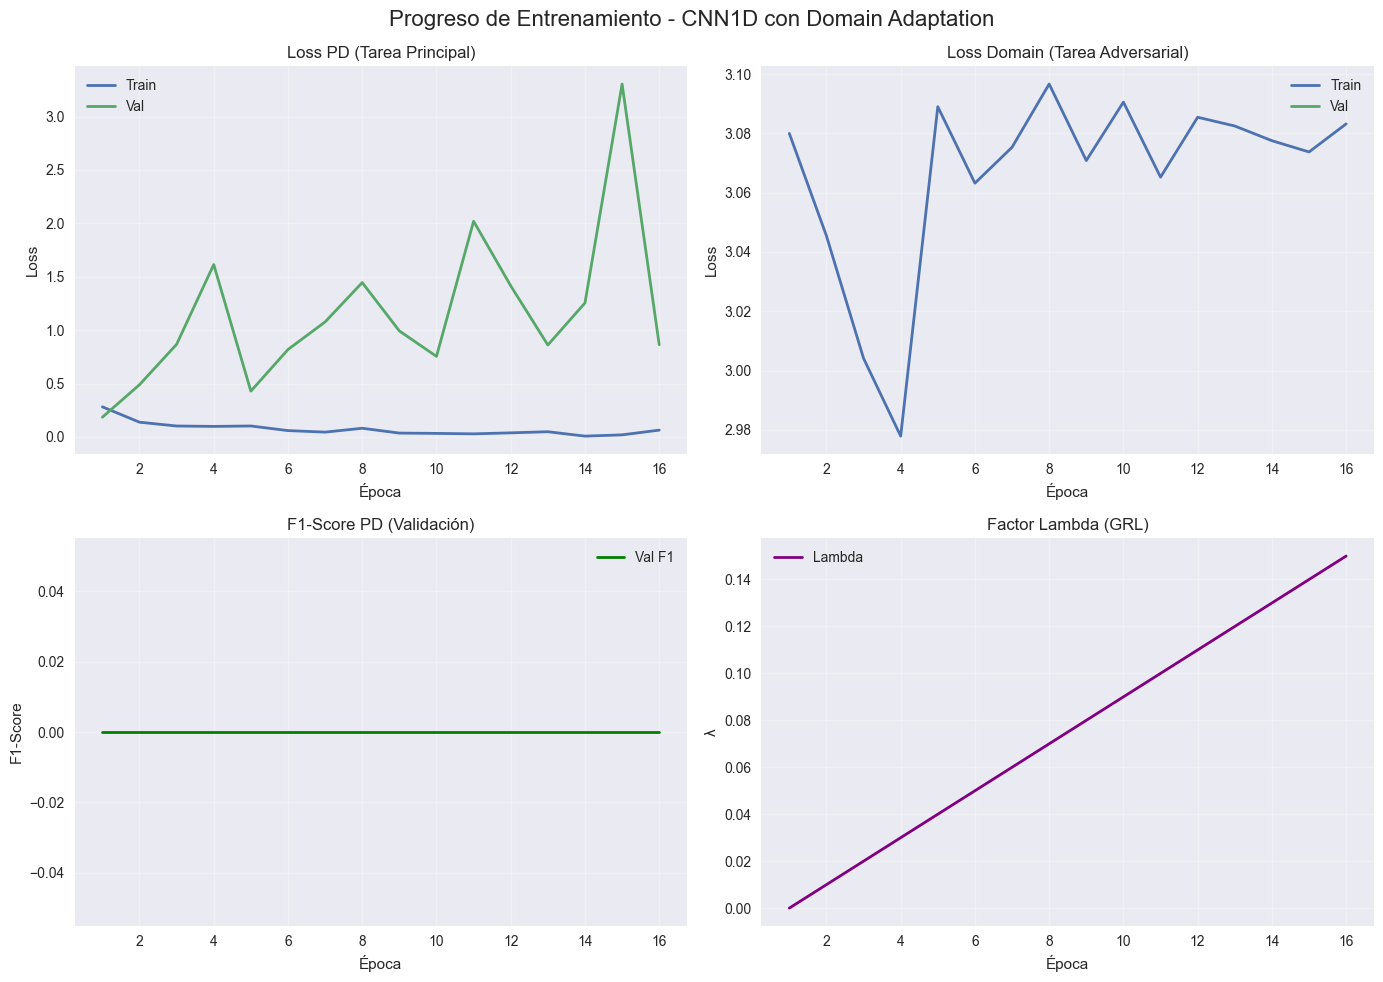

✅ Gráfica de progreso guardada en: results\cnn1d_da\training_progress_1d_da.png


In [9]:
# ============================================================
# VISUALIZACIÓN 1: PROGRESO DE ENTRENAMIENTO
# ============================================================

print("\n" + "="*70)
print("📊 VISUALIZACIÓN: PROGRESO DE ENTRENAMIENTO")
print("="*70)

plot_1d_training_progress(
    history,
    save_path=save_dir / "training_progress_1d_da.png",
    show=True
)

print(f"✅ Gráfica de progreso guardada en: {save_dir / 'training_progress_1d_da.png'}")



📊 VISUALIZACIÓN: MATRIZ DE CONFUSIÓN (PATIENT-LEVEL)
💾 Matriz guardada en: results\cnn1d_da\confusion_matrix_patient_1d_da.png


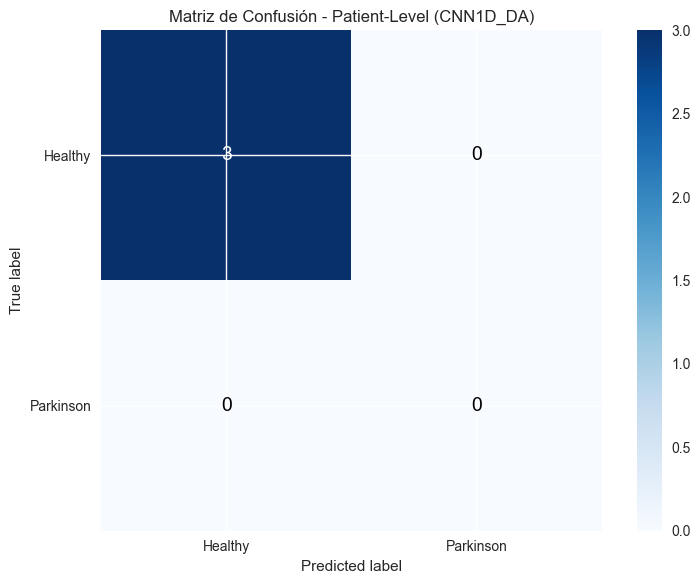

✅ Matriz de confusión guardada en: results\cnn1d_da\confusion_matrix_patient_1d_da.png


In [10]:
# ============================================================
# VISUALIZACIÓN 2: CONFUSION MATRIX (PATIENT-LEVEL)
# ============================================================

print("\n" + "="*70)
print("📊 VISUALIZACIÓN: MATRIZ DE CONFUSIÓN (PATIENT-LEVEL)")
print("="*70)

plot_simple_confusion_matrix(
    cm_patient,
    class_names=["Healthy", "Parkinson"],
    title="Matriz de Confusión - Patient-Level (CNN1D_DA)",
    save_path=save_dir / "confusion_matrix_patient_1d_da.png",
    show=True
)

print(f"✅ Matriz de confusión guardada en: {save_dir / 'confusion_matrix_patient_1d_da.png'}")



🔬 VISUALIZACIÓN: t-SNE DE EMBEDDINGS

🔄 Computando t-SNE (perplexity=30)...
💾 t-SNE guardado en: results\cnn1d_da\tsne_embeddings_1d_da.png


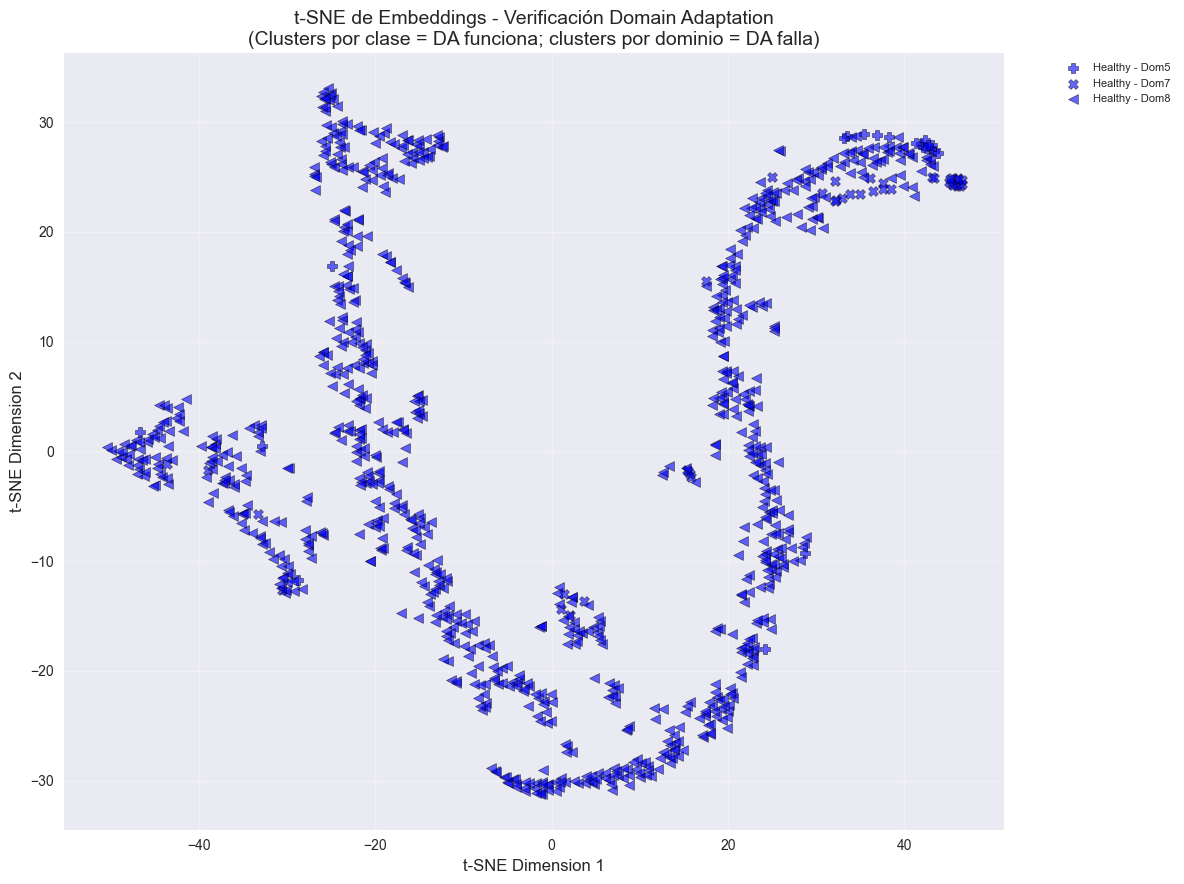


✅ t-SNE guardado en: results\cnn1d_da\tsne_embeddings_1d_da.png

💡 Interpretación:
   • Clusters por CLASE (HC/PD) = DA funciona ✓
   • Clusters por DOMINIO = DA falla ✗


In [11]:
# ============================================================
# VISUALIZACIÓN 3: t-SNE DE EMBEDDINGS (VERIFICACIÓN DA)
# ============================================================

print("\n" + "="*70)
print("🔬 VISUALIZACIÓN: t-SNE DE EMBEDDINGS")
print("="*70)

plot_tsne_embeddings(
    embeddings=all_embeddings,
    labels=all_labels,
    domains=all_domains,
    save_path=save_dir / "tsne_embeddings_1d_da.png",
    show=True,
    perplexity=30,
    random_state=42
)

print(f"\n✅ t-SNE guardado en: {save_dir / 'tsne_embeddings_1d_da.png'}")
print("\n💡 Interpretación:")
print("   • Clusters por CLASE (HC/PD) = DA funciona ✓")
print("   • Clusters por DOMINIO = DA falla ✗")
print("="*70)


## 9. Resumen Final

Comparación de métricas segment-level vs patient-level.


In [12]:
# ============================================================
# RESUMEN FINAL
# ============================================================

print("\n" + "="*70)
print("📋 RESUMEN FINAL")
print("="*70)

print(f"\n🎯 MODELO: CNN1D_DA (con Atención Temporal y Domain Adaptation)")
print(f"\n📊 DATASET:")
print(f"   • Total muestras: {len(X_combined)}")
print(f"   • Train: {len(X_train)} samples | {len(set(patient_ids_train))} pacientes")
print(f"   • Val:   {len(X_val)} samples | {len(set(patient_ids_val))} pacientes")
print(f"   • Test:  {len(X_test)} samples | {len(set(patient_ids_test))} pacientes")
print(f"   • Dominios: {n_domains}")

print(f"\n🏆 MEJOR MODELO (Época {best_epoch}):")
print(f"   • Val Loss PD: {best_val_loss_pd:.4f}")

print(f"\n📈 COMPARACIÓN SEGMENT-LEVEL vs PATIENT-LEVEL:")
print(f"   {'Métrica':<15} {'Segment':<10} {'Patient':<10} {'Mejora':<10}")
print(f"   {'-'*45}")

seg_acc = test_metrics['acc_pd']
pat_acc = patient_metrics['acc']
print(f"   {'Accuracy':<15} {seg_acc:<10.4f} {pat_acc:<10.4f} {(pat_acc-seg_acc)*100:+.2f}%")

seg_f1 = test_metrics['f1_pd']
pat_f1 = patient_metrics['f1']
print(f"   {'F1-Score':<15} {seg_f1:<10.4f} {pat_f1:<10.4f} {(pat_f1-seg_f1)*100:+.2f}%")

seg_prec = test_metrics['precision_pd']
pat_prec = patient_metrics['precision']
print(f"   {'Precision':<15} {seg_prec:<10.4f} {pat_prec:<10.4f} {(pat_prec-seg_prec)*100:+.2f}%")

seg_rec = test_metrics['recall_pd']
pat_rec = patient_metrics['recall']
print(f"   {'Recall':<15} {seg_rec:<10.4f} {pat_rec:<10.4f} {(pat_rec-seg_rec)*100:+.2f}%")

print(f"\n📁 ARCHIVOS GUARDADOS EN: {save_dir}")
print(f"   ✓ best_model_1d_da.pth")
print(f"   ✓ test_metrics_1d_da.json")
print(f"   ✓ training_progress_1d_da.png")
print(f"   ✓ confusion_matrix_patient_1d_da.png")
print(f"   ✓ tsne_embeddings_1d_da.png")

print("\n" + "="*70)
print("✅ PIPELINE COMPLETADO EXITOSAMENTE")
print("="*70)

print("\n💡 NOTAS:")
print("   • Patient-level aggregation reduce ruido de segmentos")
print("   • t-SNE verifica que DA mezcla dominios correctamente")
print("   • Comparar con CNN2D_DA para análisis completo")
print("="*70)



📋 RESUMEN FINAL

🎯 MODELO: CNN1D_DA (con Atención Temporal y Domain Adaptation)

📊 DATASET:
   • Total muestras: 2772
   • Train: 1600 samples | 9 pacientes
   • Val:   120 samples | 2 pacientes
   • Test:  1052 samples | 3 pacientes
   • Dominios: 26

🏆 MEJOR MODELO (Época 1):
   • Val Loss PD: 0.1852

📈 COMPARACIÓN SEGMENT-LEVEL vs PATIENT-LEVEL:
   Métrica         Segment    Patient    Mejora    
   ---------------------------------------------
   Accuracy        0.7357     1.0000     +26.43%
   F1-Score        0.0000     0.0000     +0.00%
   Precision       0.0000     0.0000     +0.00%
   Recall          0.0000     0.0000     +0.00%

📁 ARCHIVOS GUARDADOS EN: results\cnn1d_da
   ✓ best_model_1d_da.pth
   ✓ test_metrics_1d_da.json
   ✓ training_progress_1d_da.png
   ✓ confusion_matrix_patient_1d_da.png
   ✓ tsne_embeddings_1d_da.png

✅ PIPELINE COMPLETADO EXITOSAMENTE

💡 NOTAS:
   • Patient-level aggregation reduce ruido de segmentos
   • t-SNE verifica que DA mezcla dominios correc